##
## The goal of this Jupyter notebook is to Finetune The parameters, in order to run Co-SLAM making sure that we chose the best possible parameter for Each scene.
##

In [1]:
from datasets.dataset import ReplicaDataset
import config
import open3d as o3d
import numpy as np
import os
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def reconstruct(path_to_bound, fx, fy, cx, cy, png_depth_scale, depth_trunc, near, far):
    cfg = config.load_config(path_to_bound)
    dataset = ReplicaDataset(cfg=cfg, basedir=cfg['data']['datadir'])
    
    H, W = dataset.H, dataset.W
    K = o3d.camera.PinholeCameraIntrinsic(W, H, fx, fy, cx, cy)
    
    voxel_length = 0.005
    volume = o3d.pipelines.integration.ScalableTSDFVolume(voxel_length=voxel_length, sdf_trunc=0.04,
                                                color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)
    for i, frame in tqdm(enumerate(dataset)):
        if i % 2 != 0:
            continue
        rgb, depth = frame["rgb"].cpu().numpy(), frame["depth"].cpu().numpy()
        c2w = frame["c2w"].cpu().numpy()
        rgb = rgb * 255
        rgb = rgb.astype(np.uint8)
        rgb = o3d.geometry.Image(rgb)
        depth = depth / png_depth_scale  # Scale depth values
        depth = depth.astype(np.float32)
        depth = o3d.geometry.Image(depth)
        rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth, depth_scale=1.0,
                                                                    depth_trunc=depth_trunc,
                                                                    convert_rgb_to_intensity=False)
        #c2w[:3, 1] *= -1
        #c2w[:3, 2] *= -1
        #w2c = np.linalg.inv(c2w)

        volume.integrate(rgbd, K, c2w)
        
    print("Extracting a triangle mesh from the volume...")
    mesh = volume.extract_triangle_mesh()
    mesh.compute_vertex_normals()
    
    o3d.visualization.draw_geometries([mesh], window_name="3D Reconstruction", width=800, height=800)

def create_sliders(path_to_yaml, set_value_fx, set_value_fy, set_value_cx, set_value_cy, set_value_depthscale, set_value_depthtrunc\
                  , set_value_near, set_value_far):
    fx_slider = widgets.FloatSlider(min=500, max=2000, step=1, value=set_value_fx, description='fx')
    fy_slider = widgets.FloatSlider(min=500, max=2000, step=1, value=set_value_fy, description='fy') 
    cx_slider = widgets.FloatSlider(min=0, max=800, step=1, value=set_value_cx, description='cx')
    cy_slider = widgets.FloatSlider(min=0, max=800, step=1, value=set_value_cy, description='cy')
    depth_scale_slider = widgets.FloatSlider(min=0.1, max=10000, step=0.1, value=set_value_depthscale, description='Depth Scale')
    depth_trunc_slider = widgets.FloatSlider(min=1, max=100, step=1, value=set_value_depthtrunc, description='Depth Trunc')
    near_slider = widgets.FloatSlider(min=0.1, max=10, step=0.1, value=set_value_near, description='Near')  
    far_slider = widgets.FloatSlider(min=1, max=100, step=1, value=set_value_far, description='Far')

    interact_manual(reconstruct, 
                    path_to_bound=fixed(path_to_yaml),
                    fx=fx_slider, fy=fy_slider, cx=cx_slider, cy=cy_slider,
                    png_depth_scale=depth_scale_slider, depth_trunc=depth_trunc_slider,
                    near=near_slider, far=far_slider)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
create_sliders(path_to_yaml='./configs/Thebox/blender_box.yaml', set_value_fx=800.0000, set_value_fy=800.0000,
               set_value_cx=320.0000, set_value_cy=240.0000, set_value_depthscale=1.5, set_value_depthtrunc=100.0,
               set_value_near=0, set_value_far=5)

interactive(children=(FloatSlider(value=800.0, description='fx', max=2000.0, min=500.0, step=1.0), FloatSlider…

## Inversing depth Images

In [6]:
import cv2
import os

# Specify the folder containing the depth images
input_folder = "./data/lego/results/"  # Current folder

# Specify the output folder for inverted depth images
output_folder = "./data/lego/results_inv/"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate over all files in the input folder
for filename in os.listdir(input_folder):
    if filename.startswith("depth") and filename.endswith(".png"):
        # Read the depth image
        image_path = os.path.join(input_folder, filename)
        depth_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Invert the depth values
        inverted_depth = cv2.bitwise_not(depth_image)
        
        # Save the inverted depth image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, inverted_depth)
        
print("Depth images inverted and saved to the output folder successfully!")

Depth images inverted and saved to the output folder successfully!


## Error handling traj.txt file

In [ ]:
import os

def validate_traj_file():
    

In [17]:
import os

def validate_traj_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    for line_num, line in enumerate(lines, start=1):
        values = line.strip().split()

        if len(values) != 16:
            print(f"Error: Line {line_num} does not contain 16 values.")
            return False

        if '\t' in line:
            print(f"Error: Line {line_num} uses tab separation instead of space.")
            return False

        for value in values:
            try:
                float(value)
            except ValueError:
                print(f"Error: Line {line_num} contains a non-numeric value: {value}")
                return False

            # if 'e' in value.lower():
            #     print(f"Warning: Line {line_num} contains a value in scientific notation: {value}")

    print("traj.txt file is valid.")
    return True

traj.txt file is valid.


In [ ]:
traj_file_path = './data/SyntheticData/chair/traj.txt'

if os.path.exists(traj_file_path):
    is_valid = validate_traj_file(traj_file_path)
else:
    print(f"Error: File not found at {traj_file_path}")

In [18]:
traj_file_path = './data/Monkey_rotating/traj.txt'

if os.path.exists(traj_file_path):
    is_valid = validate_traj_file(traj_file_path)
else:
    print(f"Error: File not found at {traj_file_path}")

traj.txt file is valid.


In [21]:
traj_file_path = './data/resulting_teabox_exr/traj.txt'

if os.path.exists(traj_file_path):
    is_valid = validate_traj_file(traj_file_path)
else:
    print(f"Error: File not found at {traj_file_path}")

traj.txt file is valid.


In [22]:
import os

def check_multiple_spaces(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    for line_num, line in enumerate(lines, start=1):
        values = line.strip().split()

        for i in range(len(values) - 1):
            if values[i].endswith(' ') or values[i+1].startswith(' '):
                print(f"Warning: Line {line_num} contains multiple spaces between numbers.")
                break

    print("Multiple spaces check completed.")

# Specify the paths to your trajectory files
traj_file_paths = [
    './data/resulting_teabox_exr/traj.txt',
    './data/Monkey_rotating/traj.txt'
]

for traj_file_path in traj_file_paths:
    if os.path.exists(traj_file_path):
        print(f"Checking file: {traj_file_path}")
        check_multiple_spaces(traj_file_path)
        print()
    else:
        print(f"Error: File not found at {traj_file_path}")
        print()

Checking file: ./data/resulting_teabox_exr/traj.txt
Multiple spaces check completed.

Checking file: ./data/Monkey_rotating/traj.txt
Multiple spaces check completed.



## Visualisation of the trajectory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, IntSlider, fixed
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def read_trajectory(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    poses = []
    for i in range(0, len(lines), 4):
        matrix = np.array([list(map(float, line.split())) for line in lines[i:i+4]])
        poses.append(matrix)
    
    return np.array(poses)

def read_trajectory_(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    poses = []
    for i in range(0, len(lines), 4):
        matrix_lines = lines[i:i+4]
        if len(matrix_lines) == 4:
            matrix = []
            for line in matrix_lines:
                values = list(map(float, line.split()))
                if len(values) == 4:
                    matrix.append(values)
            if len(matrix) == 4:
                poses.append(np.array(matrix))
    
    return np.array(poses)

def plot_trajectory(poses, frame=0):
    positions = poses[:, :3, 3]
    orientations = poses[:, :3, :3]
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the trajectory
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-')
    
    # Plot start and end points
    ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], c='g', s=100, label='Start')
    ax.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2], c='r', s=100, label='End')
    
    # Plot current position and orientation
    pos = positions[frame]
    orient = orientations[frame]
    arrow_length = 0.5
    
    ax.quiver(pos[0], pos[1], pos[2], orient[0, 0], orient[1, 0], orient[2, 0], color='r', length=arrow_length, label='X')
    ax.quiver(pos[0], pos[1], pos[2], orient[0, 1], orient[1, 1], orient[2, 1], color='g', length=arrow_length, label='Y')
    ax.quiver(pos[0], pos[1], pos[2], orient[0, 2], orient[1, 2], orient[2, 2], color='b', length=arrow_length, label='Z')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Camera Trajectory (Frame {frame})')
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [2]:
# Load the trajectory data
file_path = './data/box_model/traj.txt'
poses = read_trajectory(file_path)

# Create an interactive plot
interactive_plot = interactive(plot_trajectory, 
                               poses=fixed(poses), 
                               frame=IntSlider(min=0, max=len(poses)-1, step=1, value=0, description='Frame'))
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Frame', max=499), Output()), _dom_classes=('widget-inter…

In [6]:
# Load the trajectory data
file_path = './comparaison_trajectories/new_chair_traj.txt'
poses = read_trajectory(file_path)

# Create an interactive plot
interactive_plot = interactive(plot_trajectory, 
                               poses=fixed(poses), 
                               frame=IntSlider(min=0, max=len(poses)-1, step=1, value=0, description='Frame'))
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Frame', max=49), Output()), _dom_classes=('widget-intera…

In [8]:
# Load the trajectory data
file_path = './comparaison_trajectories/room1_traj.txt'
poses = read_trajectory(file_path)

# Create an interactive plot
interactive_plot = interactive(plot_trajectory, 
                               poses=fixed(poses), 
                               frame=IntSlider(min=0, max=len(poses)-1, step=1, value=0, description='Frame'))
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Frame', max=499), Output()), _dom_classes=('widget-inter…

In [3]:
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interactive, IntSlider
from plotly.subplots import make_subplots

def read_trajectory(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    poses = []
    for i in range(0, len(lines), 4):
        matrix = np.array([list(map(float, line.split())) for line in lines[i:i+4]])
        poses.append(matrix)
    
    return np.array(poses)

def plot_trajectory(frame=0):
    positions = poses[:, :3, 3]
    orientations = poses[:, :3, :3]
    
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scene'}]])
    
    # Plot the trajectory
    fig.add_trace(go.Scatter3d(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2],
                               mode='lines', line=dict(color='blue', width=2),
                               name='Trajectory'))
    
    # Plot start and end points
    fig.add_trace(go.Scatter3d(x=[positions[0, 0]], y=[positions[0, 1]], z=[positions[0, 2]],
                               mode='markers', marker=dict(size=5, color='green'),
                               name='Start'))
    fig.add_trace(go.Scatter3d(x=[positions[-1, 0]], y=[positions[-1, 1]], z=[positions[-1, 2]],
                               mode='markers', marker=dict(size=5, color='red'),
                               name='End'))
    
    # Plot current position and orientation
    pos = positions[frame]
    orient = orientations[frame]
    arrow_length = 0.5
    
    for i, color in enumerate(['red', 'green', 'blue']):
        fig.add_trace(go.Scatter3d(x=[pos[0], pos[0] + arrow_length * orient[0, i]],
                                   y=[pos[1], pos[1] + arrow_length * orient[1, i]],
                                   z=[pos[2], pos[2] + arrow_length * orient[2, i]],
                                   mode='lines', line=dict(color=color, width=3),
                                   name=f'{"XYZ"[i]}-axis'))
    
    # Set layout
    fig.update_layout(scene=dict(
                        xaxis_title='X',
                        yaxis_title='Y',
                        zaxis_title='Z',
                        aspectmode='data'),
                      title=f'Camera Trajectory (Frame {frame})',
                      height=800,
                      width=800)
    
    fig.show()

In [4]:
# Load the trajectory data
file_path = './data/box_model/traj.txt'
poses = read_trajectory(file_path)

# Create an interactive plot
interactive_plot = interactive(plot_trajectory, 
                               frame=IntSlider(min=0, max=len(poses)-1, step=1, value=0, description='Frame'))
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Frame', max=499), Output()), _dom_classes=('widget-inter…

In [5]:
# Load the trajectory data
file_path = './comparaison_trajectories/room1_traj.txt'
poses = read_trajectory(file_path)

# Create an interactive plot
interactive_plot = interactive(plot_trajectory, 
                               frame=IntSlider(min=0, max=len(poses)-1, step=1, value=0, description='Frame'))
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Frame', max=499), Output()), _dom_classes=('widget-inter…

In [12]:
# Load the trajectory data
file_path = './comparaison_trajectories/'
poses = read_trajectory(file_path)

# Create an interactive plot
interactive_plot = interactive(plot_trajectory, 
                               frame=IntSlider(min=0, max=len(poses)-1, step=1, value=0, description='Frame'))
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Frame', max=49), Output()), _dom_classes=('widget-intera…

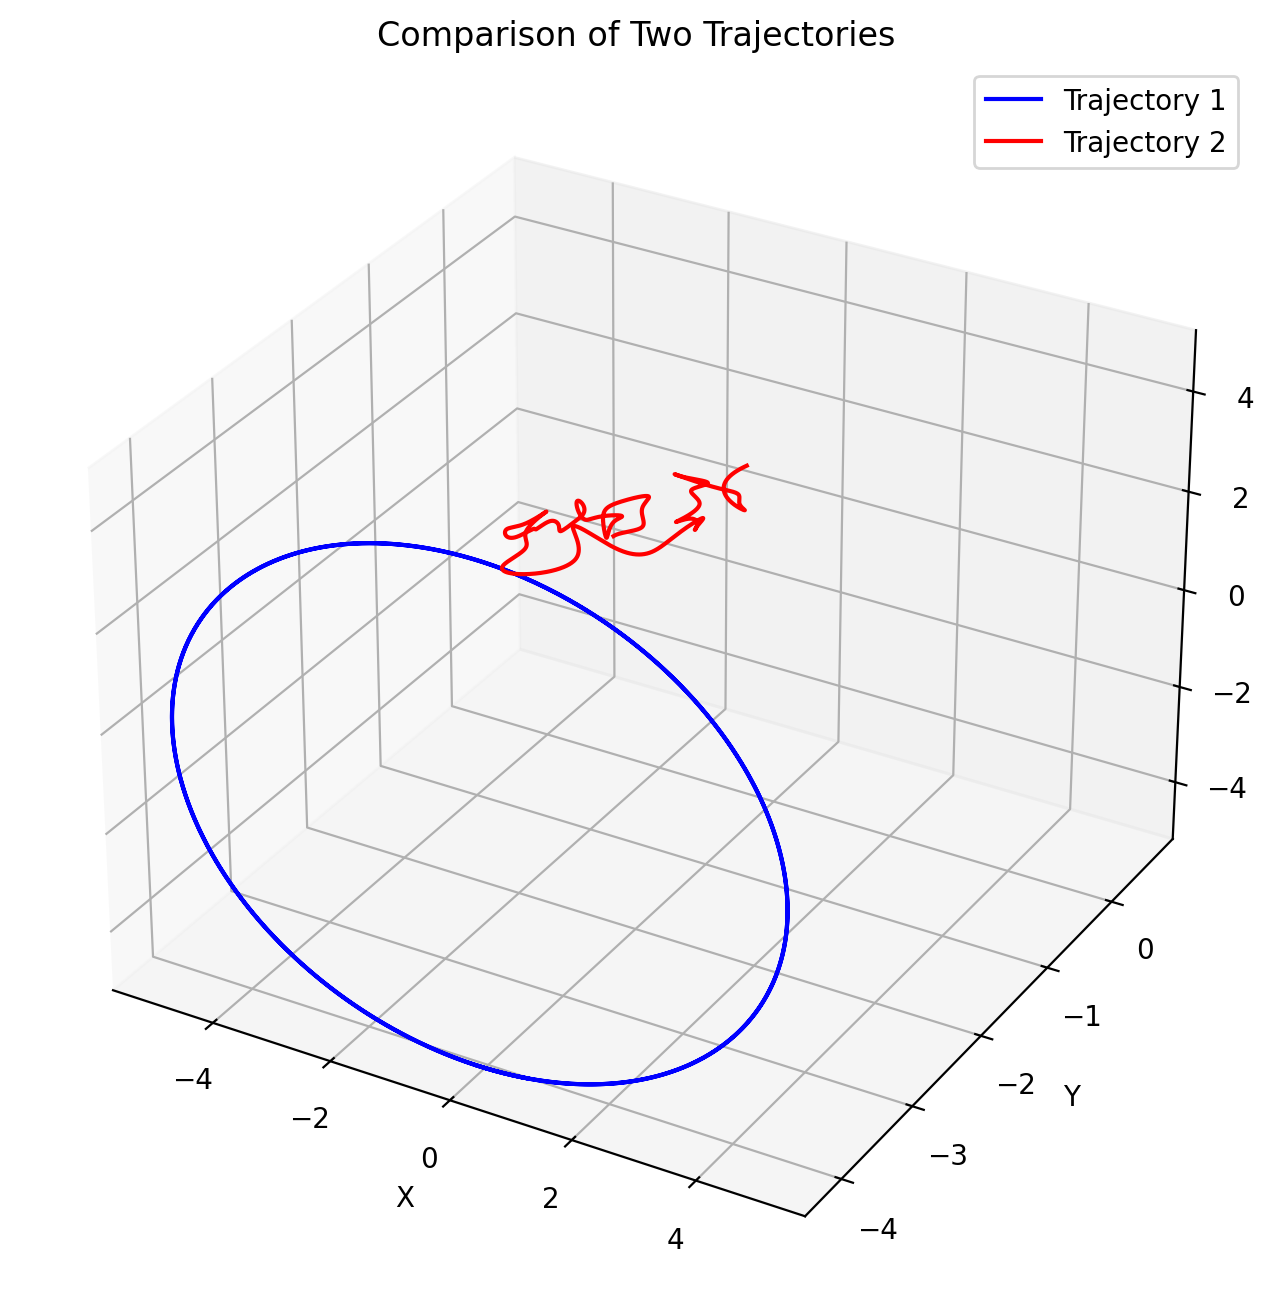

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_trajectory(file_path):
    trajectory = []
    with open(file_path, 'r') as f:
        for line in f:
            # Parse the line and extract the translation (last column of the matrix)
            values = list(map(float, line.split()))
            translation = np.array(values[3::4])[:3]  # Take only x, y, z
            trajectory.append(translation)
    return np.array(trajectory)

def plot_trajectories(traj1, traj2):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the first trajectory
    ax.plot(traj1[:, 0], traj1[:, 1], traj1[:, 2], label='Trajectory 1', color='blue')
    
    # Plot the second trajectory
    ax.plot(traj2[:, 0], traj2[:, 1], traj2[:, 2], label='Trajectory 2', color='red')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Comparison of Two Trajectories')

    # Add a legend
    ax.legend()

    plt.show()

# Read trajectories from both files
traj1 = read_trajectory('./data/box_model/traj.txt')
traj2 = read_trajectory('./data/Replica/room1/traj.txt')  # Assuming the second file is named 'traj2.txt'




# Plot the trajectories
plot_trajectories(traj1, traj2)

Trajectory 1 shape: (2000, 3)
Trajectory 2 shape: (2000, 3)


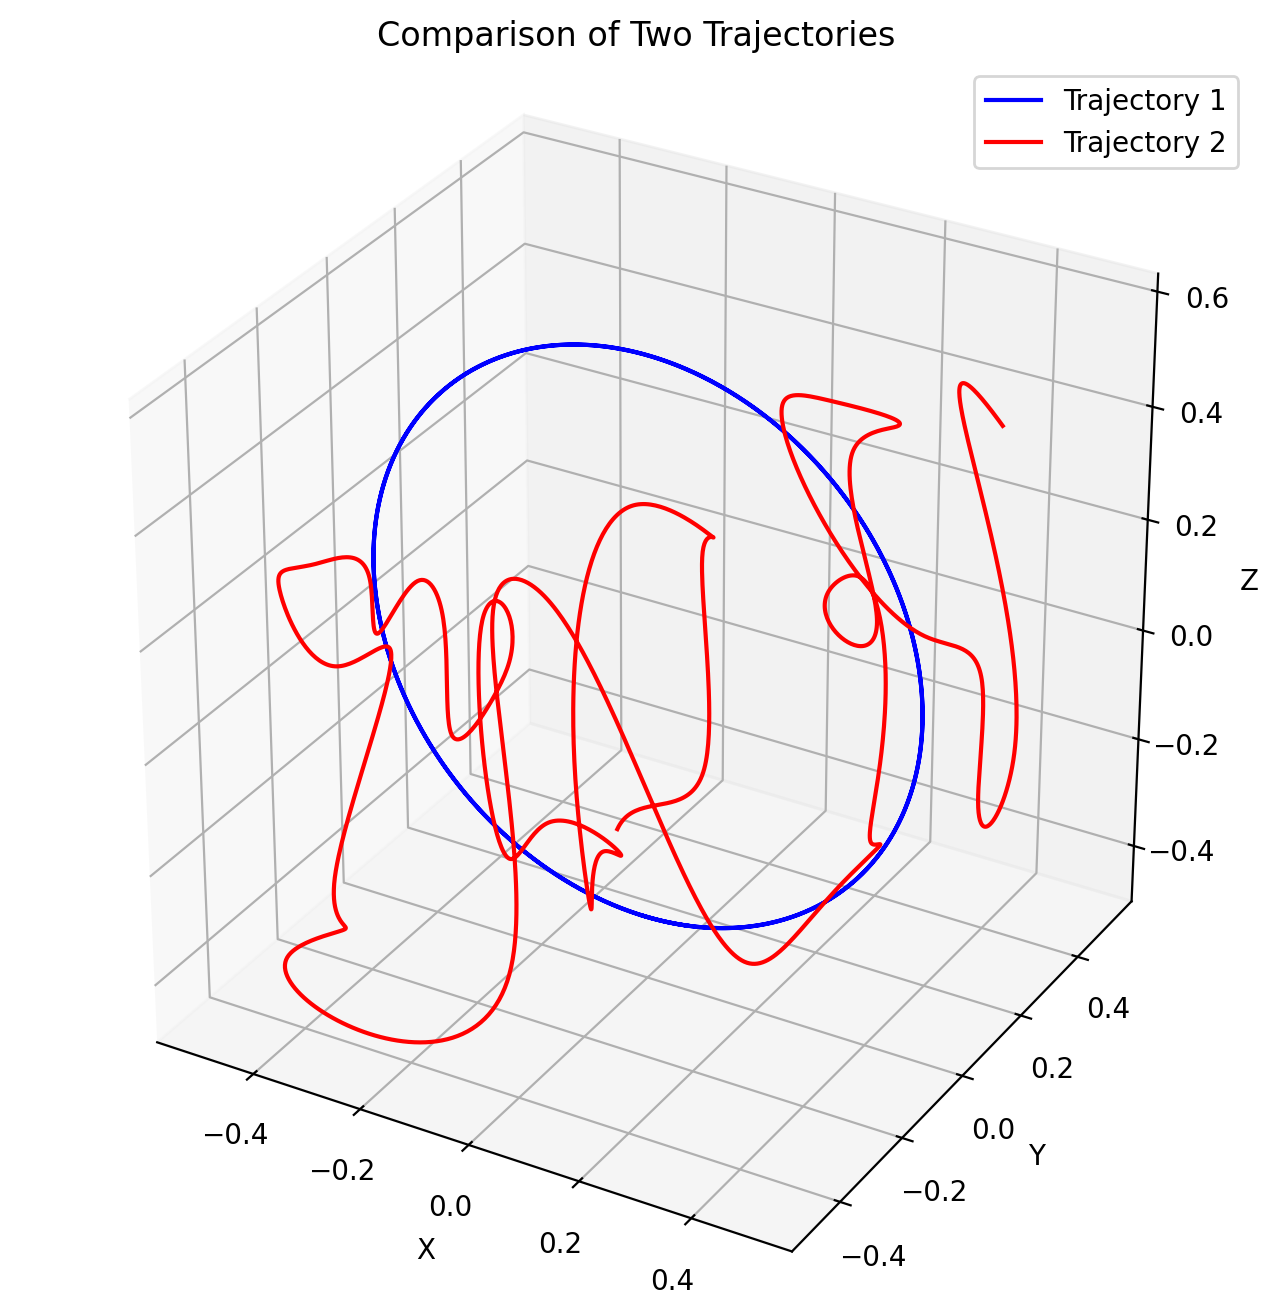

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_trajectory(file_path):
    trajectory = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                values = list(map(float, line.split()))
                translation = np.array(values[3::4])[:3]  # Take only x, y, z
                if np.all(np.isfinite(translation)):
                    trajectory.append(translation)
                else:
                    print(f"Skipping non-finite values: {translation}")
            except ValueError as e:
                print(f"Error parsing line: {line.strip()}")
                print(f"Error message: {str(e)}")
    return np.array(trajectory)

def plot_trajectories(traj1, traj2, normalize=True, center=True):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    def safe_normalize(traj):
        traj_range = np.ptp(traj, axis=0)
        traj_range[traj_range == 0] = 1  # Avoid division by zero
        return (traj - np.min(traj, axis=0)) / traj_range

    if normalize:
        traj1 = safe_normalize(traj1)
        traj2 = safe_normalize(traj2)
    
    if center:
        traj1 = traj1 - np.mean(traj1, axis=0)
        traj2 = traj2 - np.mean(traj2, axis=0)
    
    ax.plot(traj1[:, 0], traj1[:, 1], traj1[:, 2], label='Trajectory 1', color='blue')
    ax.plot(traj2[:, 0], traj2[:, 1], traj2[:, 2], label='Trajectory 2', color='red')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Comparison of Two Trajectories')
    ax.legend()
    
    # Set aspect ratio to be equal
    max_range = np.array([traj1.ptp(axis=0).max(), traj2.ptp(axis=0).max()]).max()
    ax.set_box_aspect((max_range, max_range, max_range))
    
    plt.show()

# Read trajectories from both files
traj1 = read_trajectory('./data/box_model/traj.txt')
traj2 = read_trajectory('./data/Replica/room1/traj.txt')

print(f"Trajectory 1 shape: {traj1.shape}")
print(f"Trajectory 2 shape: {traj2.shape}")

# Plot the trajectories
plot_trajectories(traj1, traj2, normalize=True, center=True)

Trajectory 1 shape: (100, 3)
Trajectory 2 shape: (100, 3)


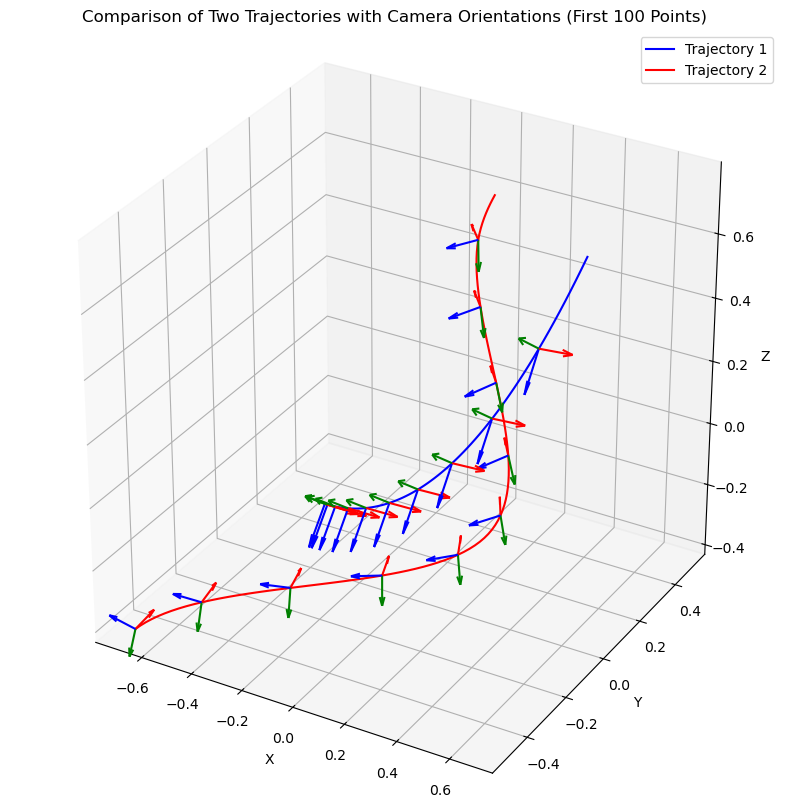

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_trajectory(file_path, max_points=100):
    trajectory = []
    rotations = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i >= max_points:
                break
            try:
                values = list(map(float, line.split()))
                matrix = np.array(values).reshape(4, 4)
                translation = matrix[:3, 3]
                rotation = matrix[:3, :3]
                if np.all(np.isfinite(translation)) and np.all(np.isfinite(rotation)):
                    trajectory.append(translation)
                    rotations.append(rotation)
                else:
                    print(f"Skipping non-finite values: {matrix}")
            except ValueError as e:
                print(f"Error parsing line: {line.strip()}")
                print(f"Error message: {str(e)}")
    return np.array(trajectory), np.array(rotations)

def plot_trajectories(traj1, rot1, traj2, rot2, normalize=True, center=True):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    def safe_normalize(traj):
        traj_range = np.ptp(traj, axis=0)
        traj_range[traj_range == 0] = 1  # Avoid division by zero
        return (traj - np.min(traj, axis=0)) / traj_range

    if normalize:
        traj1 = safe_normalize(traj1)
        traj2 = safe_normalize(traj2)
    
    if center:
        traj1 = traj1 - np.mean(traj1, axis=0)
        traj2 = traj2 - np.mean(traj2, axis=0)
    
    # Plot trajectories
    ax.plot(traj1[:, 0], traj1[:, 1], traj1[:, 2], label='Trajectory 1', color='blue')
    ax.plot(traj2[:, 0], traj2[:, 1], traj2[:, 2], label='Trajectory 2', color='red')
    
    # Plot camera directions
    def plot_directions(traj, rot, color):
        for i in range(0, len(traj), max(1, len(traj)//10)):  # Plot 10 arrows along the trajectory
            pos = traj[i]
            dir_x = rot[i] @ np.array([1, 0, 0])
            dir_y = rot[i] @ np.array([0, 1, 0])
            dir_z = rot[i] @ np.array([0, 0, 1])
            scale = 0.1  # Adjust this to change arrow length
            ax.quiver(pos[0], pos[1], pos[2], dir_x[0], dir_x[1], dir_x[2], color='r', length=scale)
            ax.quiver(pos[0], pos[1], pos[2], dir_y[0], dir_y[1], dir_y[2], color='g', length=scale)
            ax.quiver(pos[0], pos[1], pos[2], dir_z[0], dir_z[1], dir_z[2], color='b', length=scale)

    plot_directions(traj1, rot1, 'blue')
    plot_directions(traj2, rot2, 'red')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Comparison of Two Trajectories with Camera Orientations (First 100 Points)')
    ax.legend()
    
    # Set aspect ratio to be equal
    max_range = np.array([traj1.ptp(axis=0).max(), traj2.ptp(axis=0).max()]).max()
    ax.set_box_aspect((max_range, max_range, max_range))
    
    plt.show()

# Read trajectories from both files (first 100 points)
traj1, rot1 = read_trajectory('./data/box_model/traj.txt', max_points=100)
traj2, rot2 = read_trajectory('./data/Replica/room1/traj.txt', max_points=100)

print(f"Trajectory 1 shape: {traj1.shape}")
print(f"Trajectory 2 shape: {traj2.shape}")

# Plot the trajectories
plot_trajectories(traj1, rot1, traj2, rot2, normalize=True, center=True)

Trajectory 1 shape: (2000, 3)


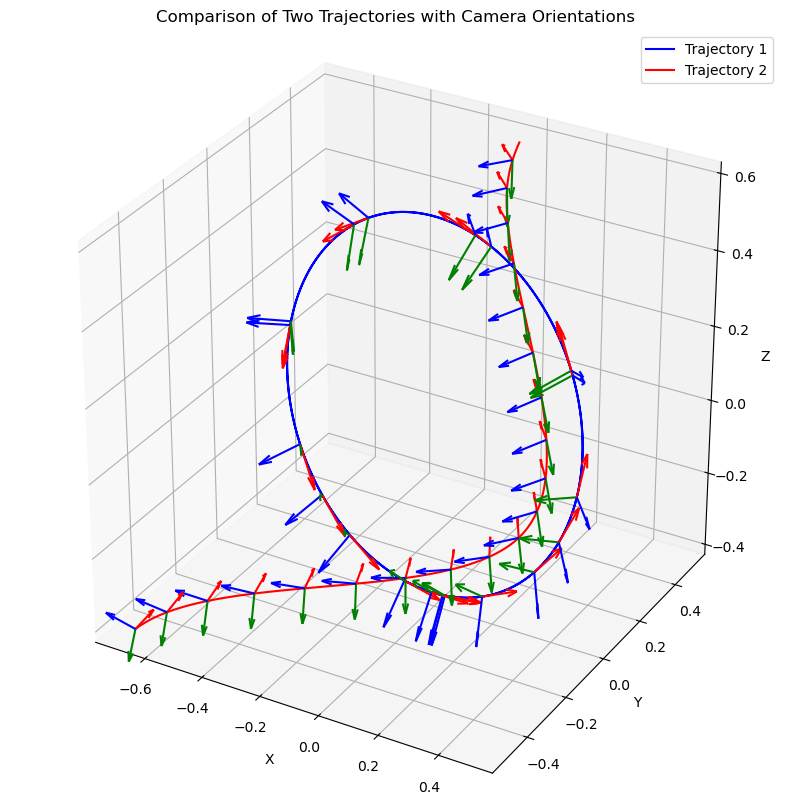

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_trajectory(file_path):
    trajectory = []
    rotations = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                values = list(map(float, line.split()))
                matrix = np.array(values).reshape(4, 4)
                translation = matrix[:3, 3]
                rotation = matrix[:3, :3]
                if np.all(np.isfinite(translation)) and np.all(np.isfinite(rotation)):
                    trajectory.append(translation)
                    rotations.append(rotation)
                else:
                    print(f"Skipping non-finite values: {matrix}")
            except ValueError as e:
                print(f"Error parsing line: {line.strip()}")
                print(f"Error message: {str(e)}")
    return np.array(trajectory), np.array(rotations)

def plot_trajectories(traj1, rot1, traj2, rot2, normalize=True, center=True):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    def safe_normalize(traj):
        traj_range = np.ptp(traj, axis=0)
        traj_range[traj_range == 0] = 1  # Avoid division by zero
        return (traj - np.min(traj, axis=0)) / traj_range

    if normalize:
        traj1 = safe_normalize(traj1)
        traj2 = safe_normalize(traj2)
    
    if center:
        traj1 = traj1 - np.mean(traj1, axis=0)
        traj2 = traj2 - np.mean(traj2, axis=0)
    
    # Plot trajectories
    ax.plot(traj1[:, 0], traj1[:, 1], traj1[:, 2], label='Trajectory 1', color='blue')
    ax.plot(traj2[:, 0], traj2[:, 1], traj2[:, 2], label='Trajectory 2', color='red')
    
    # Plot camera directions
    def plot_directions(traj, rot, color):
        for i in range(0, len(traj), len(traj)//20):  # Plot every 20th point to avoid clutter
            pos = traj[i]
            dir_x = rot[i] @ np.array([1, 0, 0])
            dir_y = rot[i] @ np.array([0, 1, 0])
            dir_z = rot[i] @ np.array([0, 0, 1])
            scale = 0.1  # Adjust this to change arrow length
            ax.quiver(pos[0], pos[1], pos[2], dir_x[0], dir_x[1], dir_x[2], color='r', length=scale)
            ax.quiver(pos[0], pos[1], pos[2], dir_y[0], dir_y[1], dir_y[2], color='g', length=scale)
            ax.quiver(pos[0], pos[1], pos[2], dir_z[0], dir_z[1], dir_z[2], color='b', length=scale)

    plot_directions(traj1, rot1, 'blue')
    plot_directions(traj2, rot2, 'red')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Comparison of Two Trajectories with Camera Orientations')
    ax.legend()
    
    # Set aspect ratio to be equal
    max_range = np.array([traj1.ptp(axis=0).max(), traj2.ptp(axis=0).max()]).max()
    ax.set_box_aspect((max_range, max_range, max_range))
    
    plt.show()

# Read trajectories from both files
traj1, rot1 = read_trajectory('./data/box_model/traj.txt')
#traj2, rot2 = read_trajectory('./data/Replica/room1/traj.txt')

print(f"Trajectory 1 shape: {traj1.shape}")
#print(f"Trajectory 2 shape: {traj2.shape}")

# Plot the trajectories
plot_trajectories(traj1, rot1, traj2, rot2, normalize=True, center=True)

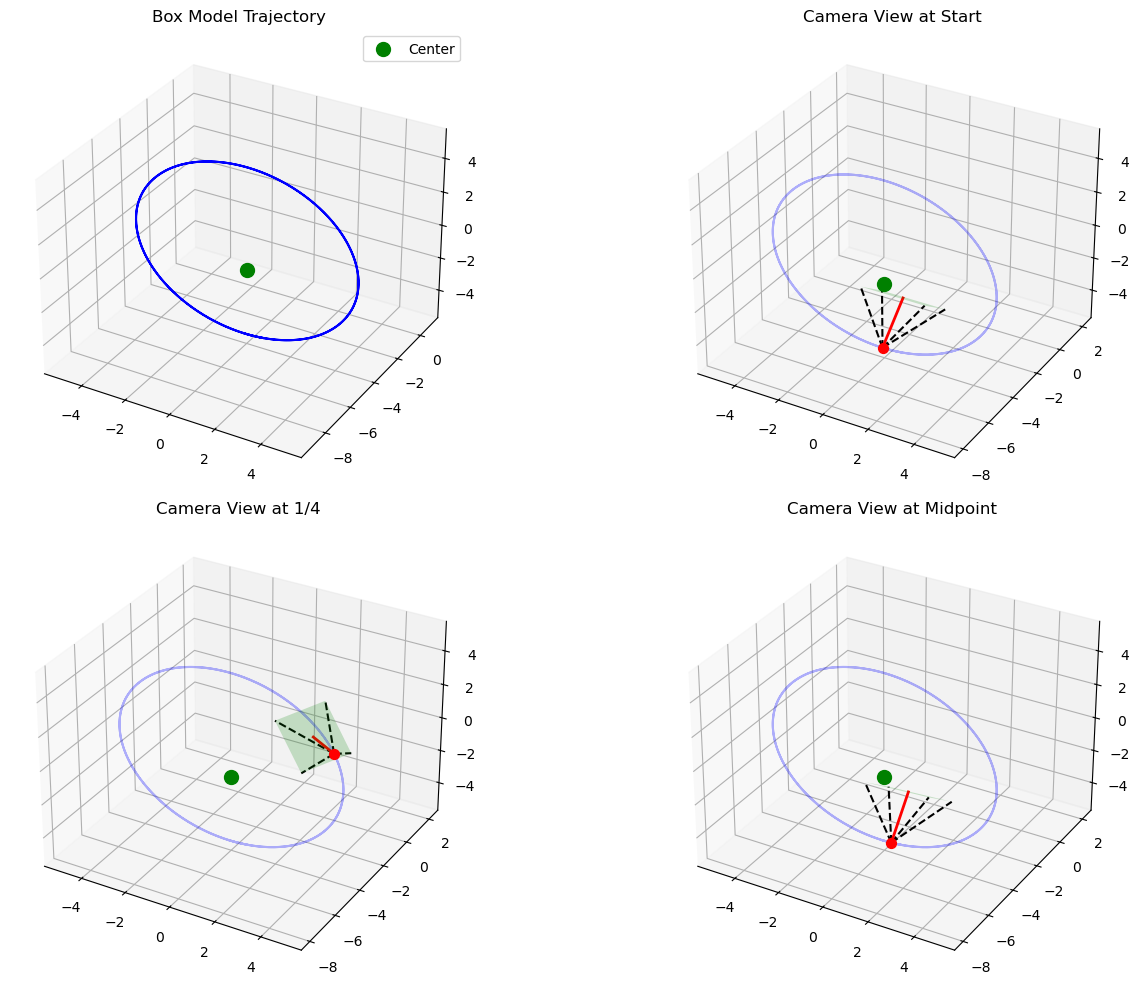

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def read_trajectory(file_path):
    trajectory = []
    rotations = []
    with open(file_path, 'r') as f:
        for line in f:
            values = list(map(float, line.split()))
            matrix = np.array(values).reshape(4, 4)
            translation = matrix[:3, 3]
            rotation = matrix[:3, :3]
            trajectory.append(translation)
            rotations.append(rotation)
    return np.array(trajectory), np.array(rotations)

def camera_view(position, rotation, fov=60, distance=2):
    angle = np.deg2rad(fov / 2)
    dx = distance * np.tan(angle)
    dy = dx * 0.75  # Assuming 4:3 aspect ratio
    corners = np.array([
        [-dx, -dy, distance],
        [dx, -dy, distance],
        [dx, dy, distance],
        [-dx, dy, distance]
    ])
    rotated_corners = corners @ rotation.T
    view_corners = rotated_corners + position
    return view_corners

def plot_camera_view(ax, position, rotation):
    view_corners = camera_view(position, rotation)
    ax.scatter(*position, color='r', s=50)
    for i in range(4):
        ax.plot([position[0], view_corners[i,0]], 
                [position[1], view_corners[i,1]], 
                [position[2], view_corners[i,2]], 'k--')
    ax.add_collection3d(Poly3DCollection([view_corners], alpha=0.2, facecolor='g'))
    
    # Add a line showing the camera's forward direction
    forward = rotation @ [0, 0, 1]  # Assuming Z is forward
    endpoint = position + forward * 2  # Adjust length as needed
    ax.plot([position[0], endpoint[0]], 
            [position[1], endpoint[1]], 
            [position[2], endpoint[2]], 'r-', linewidth=2)

def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

# Read trajectory data from file
traj1, rot1 = read_trajectory('./data/box_model/traj_modified.txt')

fig = plt.figure(figsize=(15, 10))

# Main trajectory plot
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot(traj1[:,0], traj1[:,1], traj1[:,2], 'b-')
ax1.set_title("Box Model Trajectory")

# Calculate the center of the trajectory
center = np.mean(traj1, axis=0)
ax1.scatter(*center, color='g', s=100, label='Center')
ax1.legend()
set_axes_equal(ax1)

# Camera views at different points
points = [0, len(traj1)//4, len(traj1)//2]
titles = ["Start", "1/4", "Midpoint"]

for i, (point, title) in enumerate(zip(points, titles)):
    ax = fig.add_subplot(2, 2, i+2, projection='3d')
    ax.plot(traj1[:,0], traj1[:,1], traj1[:,2], 'b-', alpha=0.3)
    plot_camera_view(ax, traj1[point], rot1[point])
    ax.scatter(*center, color='g', s=100)
    ax.set_title(f"Camera View at {title}")
    set_axes_equal(ax)

plt.tight_layout()
plt.show()

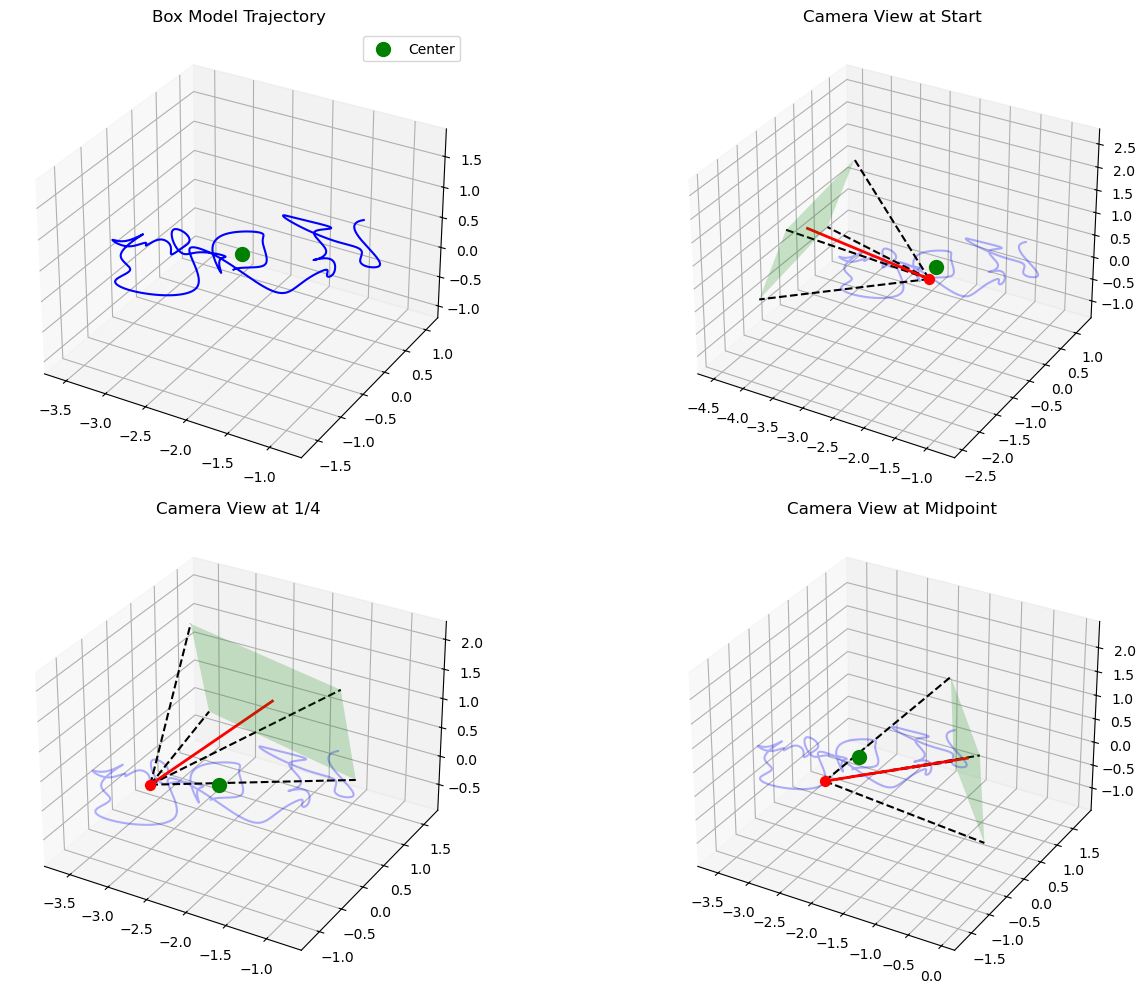

In [9]:

# Read trajectory data from file
traj1, rot1 = read_trajectory('./data/Replica/room1/traj.txt')

fig = plt.figure(figsize=(15, 10))

# Main trajectory plot
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot(traj1[:,0], traj1[:,1], traj1[:,2], 'b-')
ax1.set_title("Box Model Trajectory")

# Calculate the center of the trajectory
center = np.mean(traj1, axis=0)
ax1.scatter(*center, color='g', s=100, label='Center')
ax1.legend()
set_axes_equal(ax1)

# Camera views at different points
points = [0, len(traj1)//4, len(traj1)//2]
titles = ["Start", "1/4", "Midpoint"]

for i, (point, title) in enumerate(zip(points, titles)):
    ax = fig.add_subplot(2, 2, i+2, projection='3d')
    ax.plot(traj1[:,0], traj1[:,1], traj1[:,2], 'b-', alpha=0.3)
    plot_camera_view(ax, traj1[point], rot1[point])
    ax.scatter(*center, color='g', s=100)
    ax.set_title(f"Camera View at {title}")
    set_axes_equal(ax)

plt.tight_layout()
plt.show()

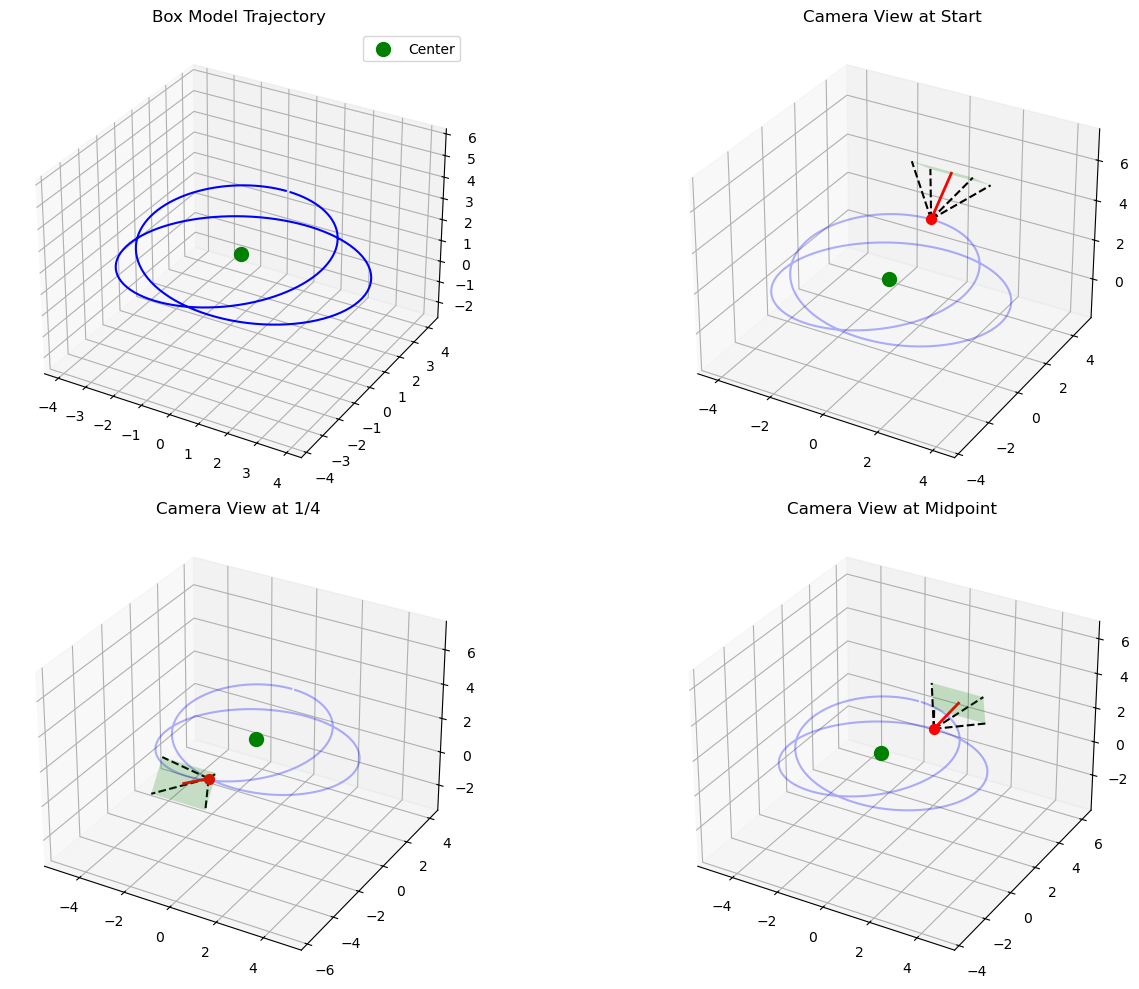

In [10]:

# Read trajectory data from file
traj1, rot1 = read_trajectory('./comparaison_trajectories/new_chair_traj.txt')

fig = plt.figure(figsize=(15, 10))

# Main trajectory plot
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot(traj1[:,0], traj1[:,1], traj1[:,2], 'b-')
ax1.set_title("Box Model Trajectory")

# Calculate the center of the trajectory
center = np.mean(traj1, axis=0)
ax1.scatter(*center, color='g', s=100, label='Center')
ax1.legend()
set_axes_equal(ax1)

# Camera views at different points
points = [0, len(traj1)//4, len(traj1)//2]
titles = ["Start", "1/4", "Midpoint"]

for i, (point, title) in enumerate(zip(points, titles)):
    ax = fig.add_subplot(2, 2, i+2, projection='3d')
    ax.plot(traj1[:,0], traj1[:,1], traj1[:,2], 'b-', alpha=0.3)
    plot_camera_view(ax, traj1[point], rot1[point])
    ax.scatter(*center, color='g', s=100)
    ax.set_title(f"Camera View at {title}")
    set_axes_equal(ax)

plt.tight_layout()
plt.show()

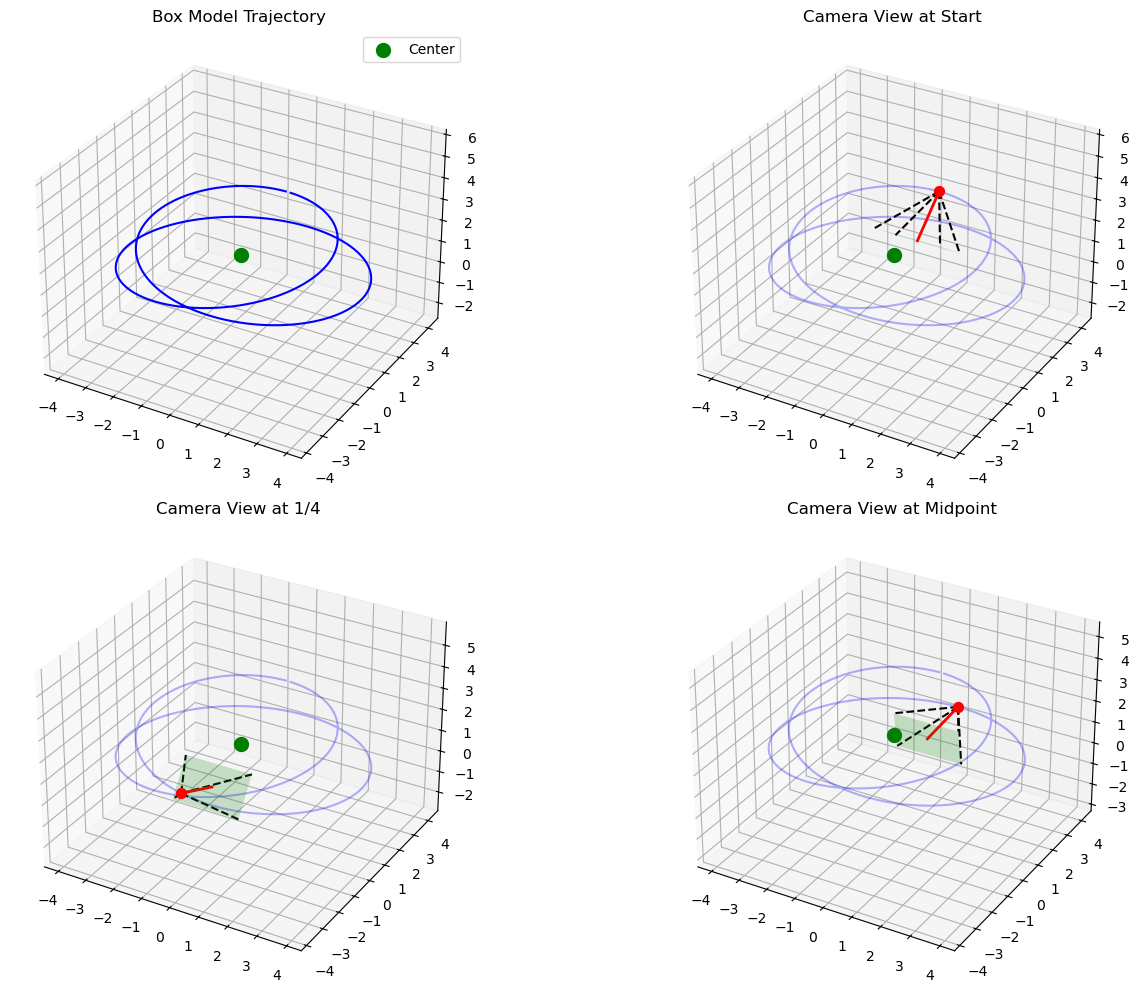

In [12]:
def read_trajectory(file_path, invert_direction=True):
    trajectory = []
    rotations = []
    with open(file_path, 'r') as f:
        for line in f:
            values = list(map(float, line.split()))
            matrix = np.array(values).reshape(4, 4)
            translation = matrix[:3, 3]
            rotation = matrix[:3, :3]
            
            if invert_direction:
                # Negate the forward vector (third column)
                rotation[:, 2] *= -1
            
            trajectory.append(translation)
            rotations.append(rotation)
    return np.array(trajectory), np.array(rotations)

# Usage:
traj1, rot1 = read_trajectory('./comparaison_trajectories/new_chair_traj.txt', invert_direction=True)

fig = plt.figure(figsize=(15, 10))

# Main trajectory plot
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot(traj1[:,0], traj1[:,1], traj1[:,2], 'b-')
ax1.set_title("Box Model Trajectory")

# Calculate the center of the trajectory
center = np.mean(traj1, axis=0)
ax1.scatter(*center, color='g', s=100, label='Center')
ax1.legend()
set_axes_equal(ax1)

# Camera views at different points
points = [0, len(traj1)//4, len(traj1)//2]
titles = ["Start", "1/4", "Midpoint"]

for i, (point, title) in enumerate(zip(points, titles)):
    ax = fig.add_subplot(2, 2, i+2, projection='3d')
    ax.plot(traj1[:,0], traj1[:,1], traj1[:,2], 'b-', alpha=0.3)
    plot_camera_view(ax, traj1[point], rot1[point])
    ax.scatter(*center, color='g', s=100)
    ax.set_title(f"Camera View at {title}")
    set_axes_equal(ax)

plt.tight_layout()
plt.show()

In [14]:
import numpy as np

def read_and_modify_trajectory(input_file, output_file):
    modified_matrices = []
    
    with open(input_file, 'r') as f:
        for line in f:
            values = line.split()
            matrix = np.array([float(v) for v in values]).reshape(4, 4)
            
            # Extract rotation and translation
            rotation = matrix[:3, :3]
            translation = matrix[:3, 3]
            
            # Invert the camera direction by negating the third column of rotation
            rotation[:, 2] *= -1
            
            # Reconstruct the modified 4x4 matrix
            modified_matrix = np.eye(4)
            modified_matrix[:3, :3] = rotation
            modified_matrix[:3, 3] = translation
            
            modified_matrices.append(modified_matrix)
    
    # Write the modified matrices to the new file
    with open(output_file, 'w') as f:
        for matrix in modified_matrices:
            # Format each number to match the original scientific notation
            line = ' '.join([f'{x:.10e}' for x in matrix.flatten()])
            f.write(line + '\n')

    print(f"Modified trajectory written to {output_file}")

# Use the function
input_file = './data/box_model/traj.txt'
output_file = './data/box_model/traj_modified.txt'
read_and_modify_trajectory(input_file, output_file)

Modified trajectory written to ./data/box_model/traj_modified.txt


## Try out the chosen Parameters.

In [10]:
from datasets.dataset import ReplicaDataset
import config
import open3d as o3d
import numpy as np
import os
from tqdm import tqdm

path_to_bound = './configs/'
cfg = config.load_config(path_to_bound)

dataset = ReplicaDataset(cfg=cfg, basedir=cfg['data']['datadir'])


H, W = dataset.H, dataset.W
fx, fy, cx, cy = dataset.fx, dataset.fy, dataset.cx, dataset.cy
K = o3d.camera.PinholeCameraIntrinsic(W, H, fx, fy, cx, cy)
voxel_length = 0.005
volume = o3d.pipelines.integration.ScalableTSDFVolume(voxel_length=voxel_length, sdf_trunc=0.04,
                                            color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

len(dataset)

0

In [ ]:
for i, frame in tqdm(enumerate(dataset)):
    if i % 2 != 0:
         continue
    rgb, depth = frame["rgb"].cpu().numpy(), frame["depth"].cpu().numpy()
    c2w = frame["c2w"].cpu().numpy()
    rgb = rgb * 255
    rgb = rgb.astype(np.uint8)
    rgb = o3d.geometry.Image(rgb)
    depth = depth.astype(np.float32)
    depth = o3d.geometry.Image(depth)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth, depth_scale=1.4,
                                                                depth_trunc=20.0,
                                                                convert_rgb_to_intensity=False)
    #c2w[:3, 1] *= -1
    #c2w[:3, 2] *= -1
    c2w[:3, 3] *= -1
    w2c = np.linalg.inv(c2w)

    
    # requires w2c
    volume.integrate(rgbd, K, w2c)

print("Extract a triangle mesh from the volume and visualize it.")
mesh = volume.extract_triangle_mesh()
mesh.compute_vertex_normals()


o3d.visualization.draw_geometries([mesh], window_name="3D Reconstruction", width=800, height=800)